In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import norm

# 1.3

In [2]:
# Parameters
S0 = 100       # initial stock price
K = 100        # strike price
r = 0.02       # risk-free rate
sigma = 0.2    # volatility
T = 1.0        # time to maturity in years
n_sims = 10  # number of Monte Carlo simulations
np.random.seed(200)
# Simulation sizes
dense_part = np.arange(10, 10_000, 1000)
sparse_part = np.arange(10_000, 1_000_001, 10000)
n_sims_list = np.unique(np.concatenate((dense_part, sparse_part)))
prices = []
ses = []

# Closed-form price of digital call
d2 = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
closed_form = np.exp(-r * T) * norm.cdf(d2)

for n_sims in n_sims_list:
    print(n_sims)
    # Monte Carlo simulation of S_T
    Z = np.random.randn(n_sims)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Payoff for binary option (1 if ST >= K, else 0)
    payoffs = (ST >= K).astype(float)
    se_payoffs = np.exp(-r * T)*(payoffs.std(ddof=1)/np.sqrt(n_sims))
    # Monte Carlo estimate
    mc_price = np.exp(-r * T) * payoffs.mean()
    prices.append(mc_price)
    ses.append(se_payoffs)


10
1010
2010
3010
4010
5010
6010
7010
8010
9010
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000


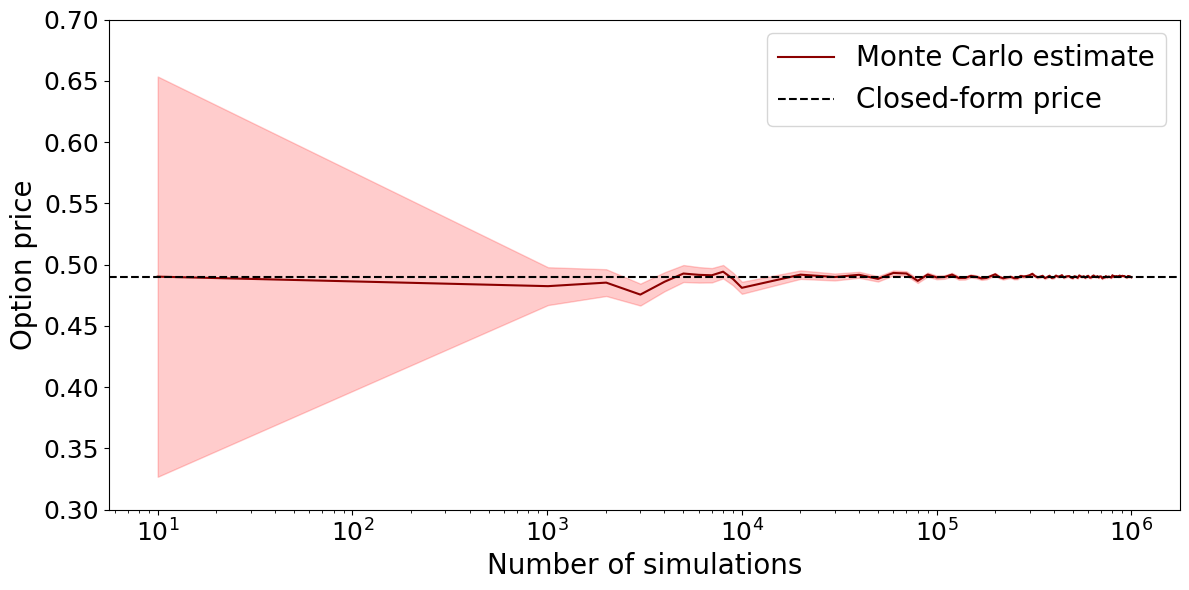

In [13]:
plt.figure(figsize=(12,6))
plt.plot(n_sims_list,prices, color="darkred", label = 'Monte Carlo estimate')
lower = np.array(prices) - np.array(ses)
upper = np.array(prices) + np.array(ses)
plt.fill_between(n_sims_list, lower, upper, color='red', alpha=0.2)
plt.axhline(closed_form, color='black', linestyle='--', label='Closed-form price')
plt.xscale('log')
plt.xlabel('Number of simulations', fontsize=20)
plt.ylabel('Option price', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0.3, 0.7)
plt.tight_layout()
plt.show()

C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\618406379.py:16: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


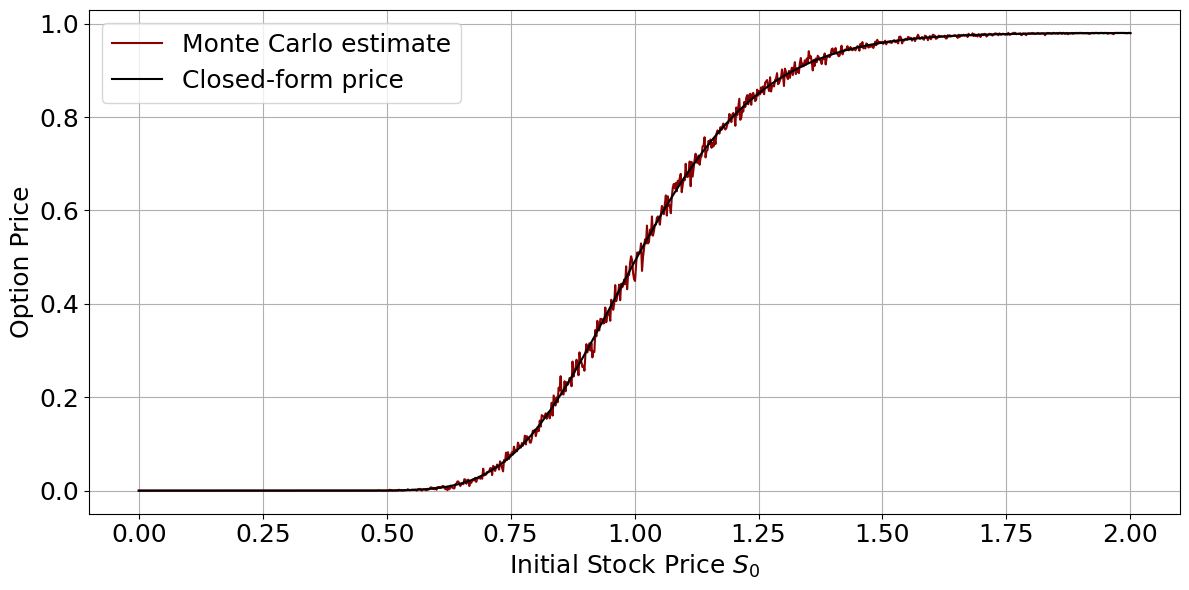

In [ ]:

# fixed parameters
K = 1.0
r = 0.02
sigma = 0.2
T = 1.0
n_sims = 1000
np.random.seed(42)

# varying initial stock prices
S0_values = np.linspace(0, 2, 1000)
mc_prices = []
analytical_prices = []

for S0 in S0_values:
    # analytical
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    analytical_price = np.exp(-r * T) * norm.cdf(d2)
    analytical_prices.append(analytical_price)

    # MC
    Z = np.random.randn(n_sims)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = (ST >= K).astype(float)
    mc_price = np.exp(-r * T) * np.mean(payoffs)
    mc_prices.append(mc_price)

# plot
plt.figure(figsize=(12, 6))
plt.plot(S0_values, mc_prices, label='Monte Carlo estimate', color='darkred')
plt.plot(S0_values, analytical_prices, label='Closed-form price', color='black')
plt.xlabel(r'Initial Stock Price $S_0$', fontsize=18)
plt.ylabel('Option Price', fontsize=18)
# plt.title('Binary Option Price vs $S_0$', fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.4 - Use implicit and Crank-Nicolson schemes to price binary options

# Main setup

In [ ]:
# Params
S0 = 1.0       # Initial stock price (as specified in the problem)
K = 1.0        # Strike price
r = 0.02     # Risk-free rate
sigma = 0.2    # Volatility
T = 1        # Time to maturity

# Grid params
Smax = 2   # Max SP 
Smin = 0.0     # Minimum SP
M = 200   # Number of SP steps
N = 200       # Number of time steps
dt = T / N     # Time step size
ds = (Smax - Smin) / M  # Stock price step size

# grid creation
S_grid = np.linspace(Smin, Smax, M+1)
t_grid = np.linspace(0, T, N+1)

def binary_call_analytical(S, t, K, r, sigma, T):
    """Analytical solution for binary call option"""
    tau = T - t
    if tau == 0:  
        return np.where(S >= K, 1.0, 0.0)
    d_minus = ((r - sigma**2/2) * tau + np.log(S/K)) / (sigma * np.sqrt(tau))
    return np.exp(-r * tau) * norm.cdf(d_minus)

def d_minus(S, K, r, sigma, tau):
    """Compute d_minus term used in the analytical formula"""
    return ((r - sigma**2/2) * tau + np.log(S/K)) / (sigma * np.sqrt(tau))

def binary_call_delta(S, t, K, r, sigma, T):
    """Calculate analytical delta of binary option"""
    tau = T - t
    if tau == 0:  
        return np.zeros_like(S)  
    d_m = d_minus(S, K, r, sigma, tau)
    return np.exp(-r * tau) * norm.pdf(d_m) / (S * sigma * np.sqrt(tau))

def binary_call_implicit(S_grid, t_grid, K, r, sigma, T):
    """Implicit scheme for binary option pricing"""
    M = len(S_grid) - 1
    N = len(t_grid) - 1
    dt = T / N
    ds = S_grid[1] - S_grid[0]
    
    # Initialize option price array
    V = np.zeros((M+1, N+1))
    
    # Terminal condition (payoff at maturity)
    V[:, N] = np.where(S_grid >= K, 1.0, 0.0)
    
    # Coefficients for the tridiagonal system
    alpha = 0.5 * sigma**2 * S_grid**2 * dt / ds**2
    beta = r * S_grid * dt / (2 * ds)
    
    for n in range(N-1, -1, -1):
        # Set up the tridiagonal system
        a = -alpha[1:-1] + beta[1:-1]  
        b = 1 + 2*alpha[1:-1] + r*dt    
        c = -alpha[1:-1] - beta[1:-1]  
        d = V[1:-1, n+1]               
        
        # Adjust for boundary conditions
        d[0] -= a[0] * V[0, n+1]  
        d[-1] -= c[-1] * V[-1, n+1]  
        
        # Solve the tridiagonal system
        V[1:-1, n] = solve_tridiagonal(a, b, c, d)
        
        # Boundary conditions
        V[0, n] = 0  
        V[-1, n] = np.exp(-r * (T - t_grid[n]))  
    
    return V

def binary_call_crank_nicolson(S_grid, t_grid, K, r, sigma, T):
    """Crank-Nicolson scheme for binary option pricing"""
    M = len(S_grid) - 1
    N = len(t_grid) - 1
    dt = T / N
    ds = S_grid[1] - S_grid[0]
    
    # Initialize option price array
    V = np.zeros((M+1, N+1))
    
    # Terminal condition (payoff at maturity)
    V[:, N] = np.where(S_grid >= K, 1.0, 0.0)
    
    # Coefficients for the tridiagonal system
    alpha = 0.25 * sigma**2 * S_grid**2 * dt / ds**2
    beta = 0.5 * r * S_grid * dt / (2 * ds)
    
    # Working backwards in time
    for n in range(N-1, -1, -1):
        # Set up the tridiagonal system
        a = -alpha[1:-1] + beta[1:-1]  
        b = 1 + 2*alpha[1:-1] + 0.5*r*dt  
        c = -alpha[1:-1] - beta[1:-1]  
        
        rhs = np.zeros(M-1)
        for j in range(1, M):
            rhs[j-1] = (alpha[j] - beta[j]) * V[j-1, n+1] + \
                      (1 - 2*alpha[j] - 0.5*r*dt) * V[j, n+1] + \
                      (alpha[j] + beta[j]) * V[j+1, n+1]
        
        rhs[0] -= a[0] * V[0, n+1]  
        rhs[-1] -= c[-1] * V[-1, n+1]  
        
        V[1:-1, n] = solve_tridiagonal(a, b, c, rhs)
        
        # Boundary 
        V[0, n] = 0  
        V[-1, n] = np.exp(-r * (T - t_grid[n]))  # Upper boundary
    
    return V

def solve_tridiagonal(a, b, c, d):
    """Solves Ax = d for tridiagonal matrix A with diagonals a (sub), b (main), c (super)"""
    n = len(d)
    c_prime = np.zeros(n)
    d_prime = np.zeros(n)
    
    # First row
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n):
        denom = b[i] - a[i] * c_prime[i - 1]
        c_prime[i] = c[i] / denom if i < n - 1 else 0.0 
        d_prime[i] = (d[i] - a[i] * d_prime[i - 1]) / denom

    # Backward substitution
    x = np.zeros(n)
    x[-1] = d_prime[-1]
    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]

    return x


# Compute Delta

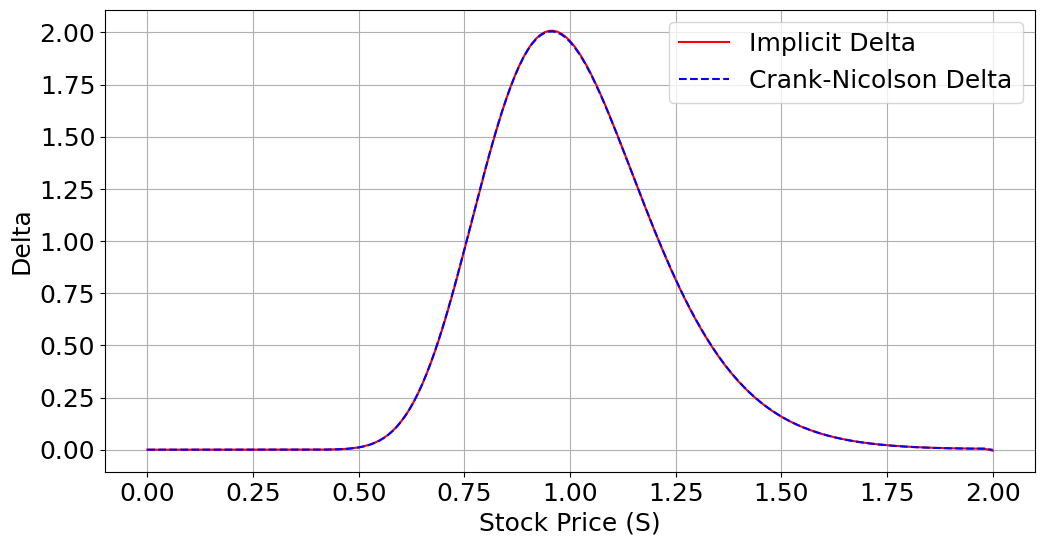

In [ ]:
# Compute option prices using both methods
V_implicit = binary_call_implicit(S_grid, t_grid, K, r, sigma, T)
V_cn = binary_call_crank_nicolson(S_grid, t_grid, K, r, sigma, T)

delta_implicit = np.zeros(M+1)
delta_cn = np.zeros(M+1)

for i in range(1, M):
    delta_implicit[i] = (V_implicit[i+1, 0] - V_implicit[i-1, 0]) / (2 * ds)
    delta_cn[i] = (V_cn[i+1, 0] - V_cn[i-1, 0]) / (2 * ds)

# Forward and backward difference at boundaries
delta_implicit[0] = (V_implicit[1, 0] - V_implicit[0, 0]) / ds
delta_implicit[M] = (V_implicit[M, 0] - V_implicit[M-1, 0]) / ds

delta_cn[0] = (V_cn[1, 0] - V_cn[0, 0]) / ds
delta_cn[M] = (V_cn[M, 0] - V_cn[M-1, 0]) / ds

# plot
plt.figure(figsize=(12, 6))
plt.plot(S_grid, delta_implicit, 'r-', label='Implicit Delta')
plt.plot(S_grid, delta_cn, 'b--', label='Crank-Nicolson Delta')
plt.xlabel('Stock Price (S)', fontsize=18)
plt.ylabel('Delta', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.title('Numerical Delta: Implicit vs Crank-Nicolson')
plt.grid(True)
plt.legend(fontsize=18)

# Not used

C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\46392093.py:25: RuntimeWarning: divide by zero encountered in log
  d_minus = ((r - sigma**2/2) * tau + np.log(S/K)) / (sigma * np.sqrt(tau))


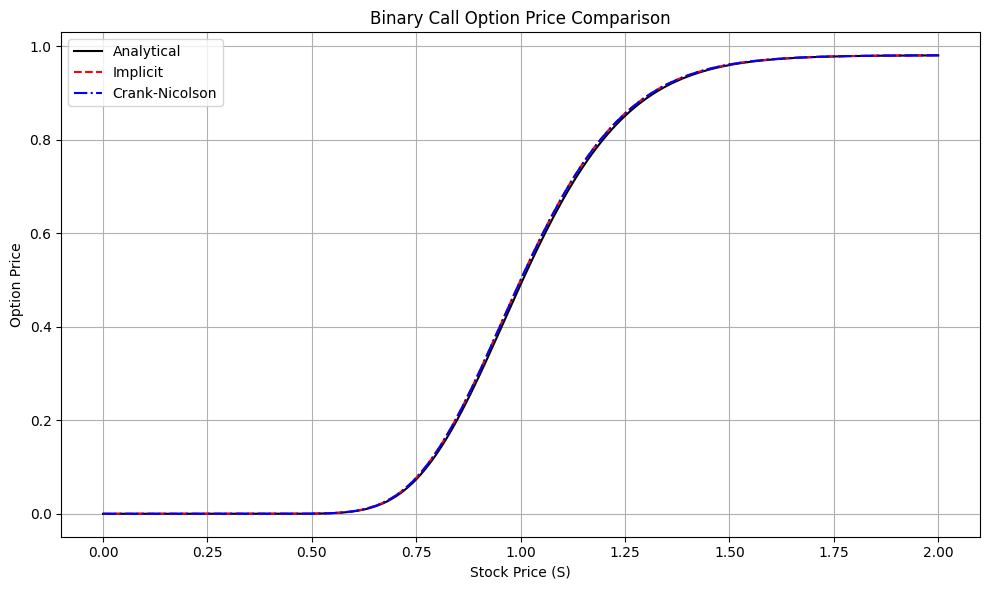

Implicit Method - Max Error: 0.009852
Crank-Nicolson Method - Max Error: 0.009804


In [7]:
# Compute option prices using both numerical methods
V_implicit = binary_call_implicit(S_grid, t_grid, K, r, sigma, T)
V_crank_nicolson = binary_call_crank_nicolson(S_grid, t_grid, K, r, sigma, T)

# Analytical solution for comparison
V_analytical = np.zeros((M+1, N+1))
for n, t in enumerate(t_grid):
    V_analytical[:, n] = binary_call_analytical(S_grid, t, K, r, sigma, T)

# Plotted comparison at t=0 (current price) 
plt.figure(figsize=(10, 6))
plt.plot(S_grid, V_analytical[:, 0], 'k-', label='Analytical')
plt.plot(S_grid, V_implicit[:, 0], 'r--', label='Implicit')
plt.plot(S_grid, V_crank_nicolson[:, 0], 'b-.', label='Crank-Nicolson')
plt.grid(True)
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Price')
plt.title('Binary Call Option Price Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate error metrics
implicit_error = np.abs(V_implicit[:, 0] - V_analytical[:, 0])
cn_error = np.abs(V_crank_nicolson[:, 0] - V_analytical[:, 0])

print(f"Implicit Method - Max Error: {np.max(implicit_error):.6f}")
print(f"Crank-Nicolson Method - Max Error: {np.max(cn_error):.6f}")


# Difference in option price

C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\1908163396.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('autumn')


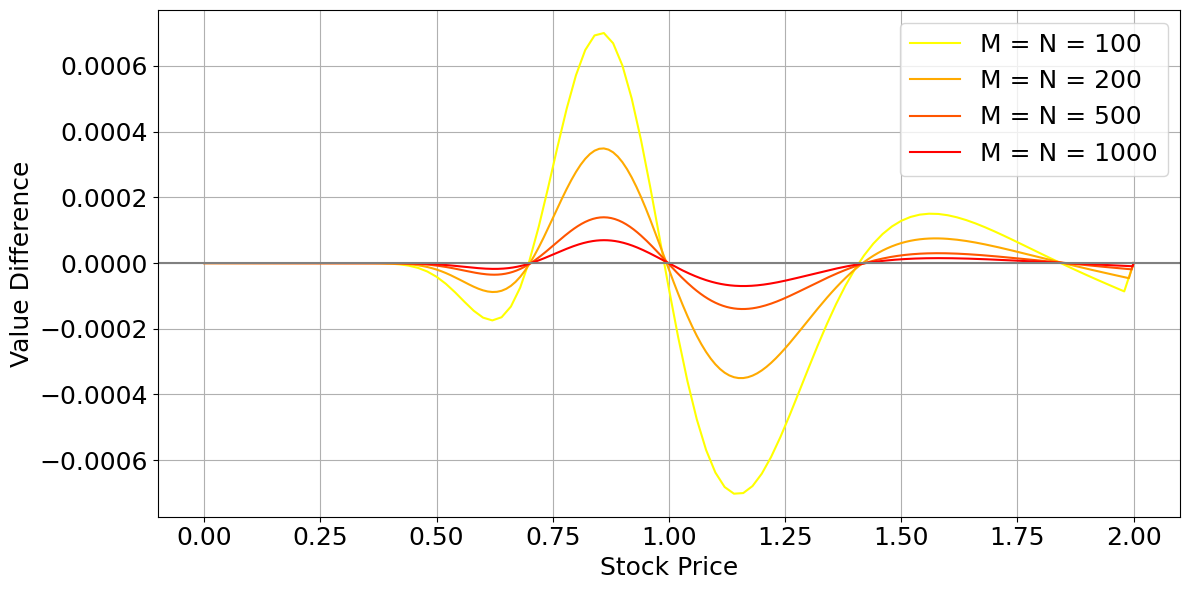

In [8]:
resolutions = [100, 200, 500, 1000]
cmap = cm.get_cmap('autumn')
colors = [cmap(1 - i / (len(resolutions) - 1)) for i in range(len(resolutions))]

plt.figure(figsize=(12, 6))

for i, res in enumerate(resolutions):
    M = N = res
    S_grid = np.linspace(Smin, Smax, M + 1)
    t_grid = np.linspace(0, T, N + 1)
    
    V_implicit = binary_call_implicit(S_grid, t_grid, K, r, sigma, T)
    V_crank = binary_call_crank_nicolson(S_grid, t_grid, K, r, sigma, T)
    
    diff = V_crank[:, 0] - V_implicit[:, 0]
    plt.plot(S_grid, diff, label=f'M = N = {res}', color=colors[i])

plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
# plt.title('Difference Between Crank-Nicolson and Implicit Methods at t=0')
plt.xlabel('Stock Price', fontsize=18)
plt.ylabel('Value Difference', fontsize=18)
plt.xticks(fontsize=18)
plt.axhline(0, color='gray')
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()




# Experiment analytical

C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\384950189.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('autumn')
C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\46392093.py:25: RuntimeWarning: divide by zero encountered in log
  d_minus = ((r - sigma**2/2) * tau + np.log(S/K)) / (sigma * np.sqrt(tau))


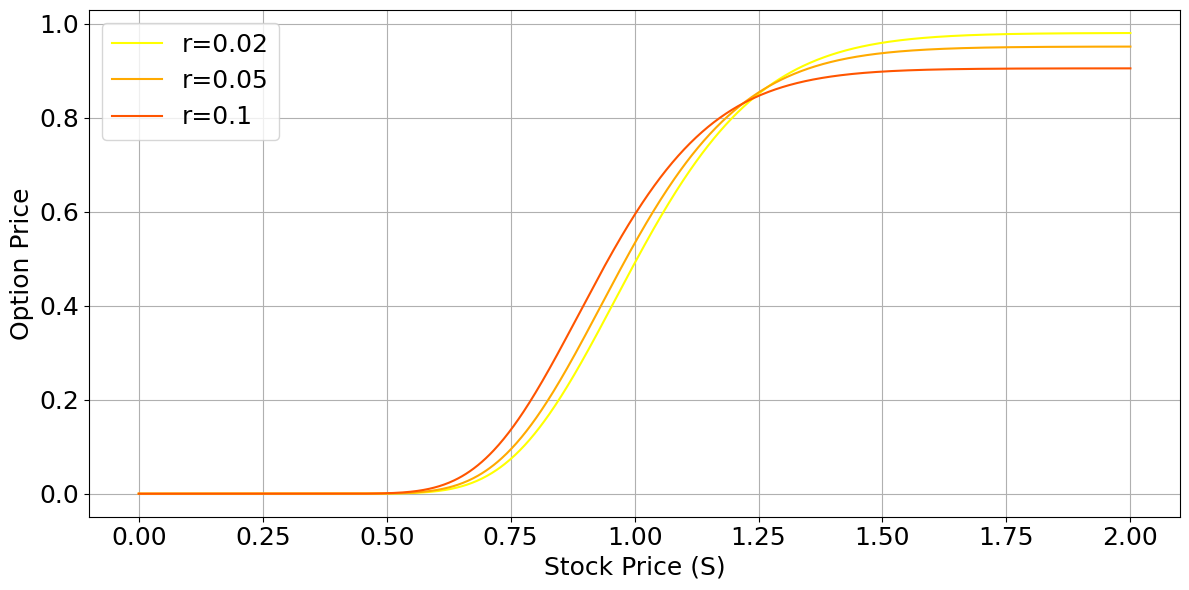

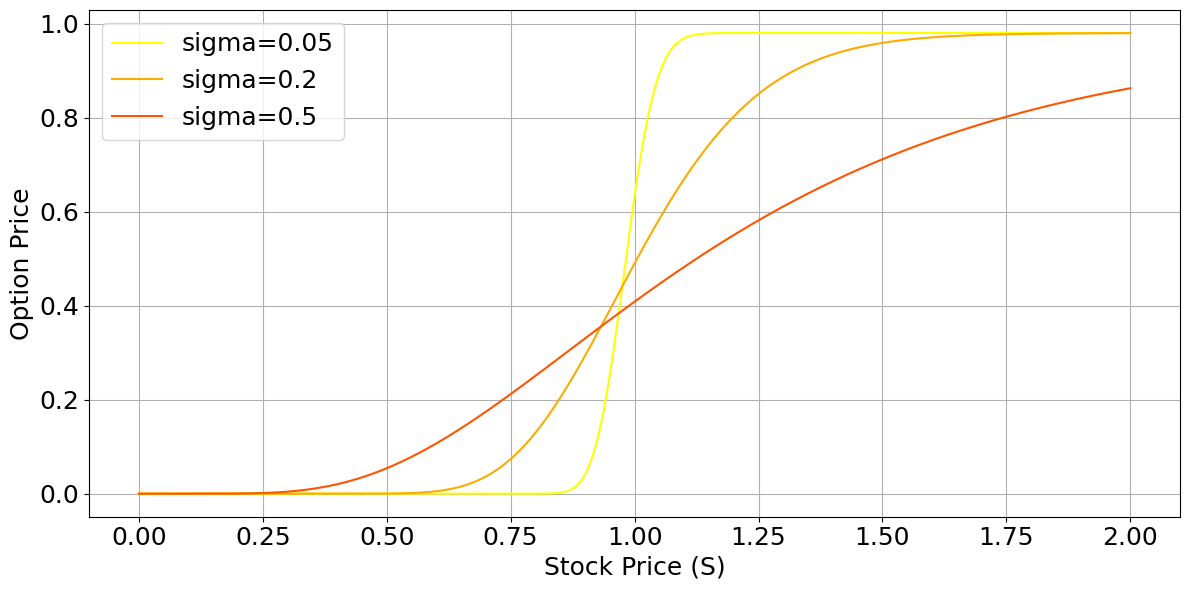

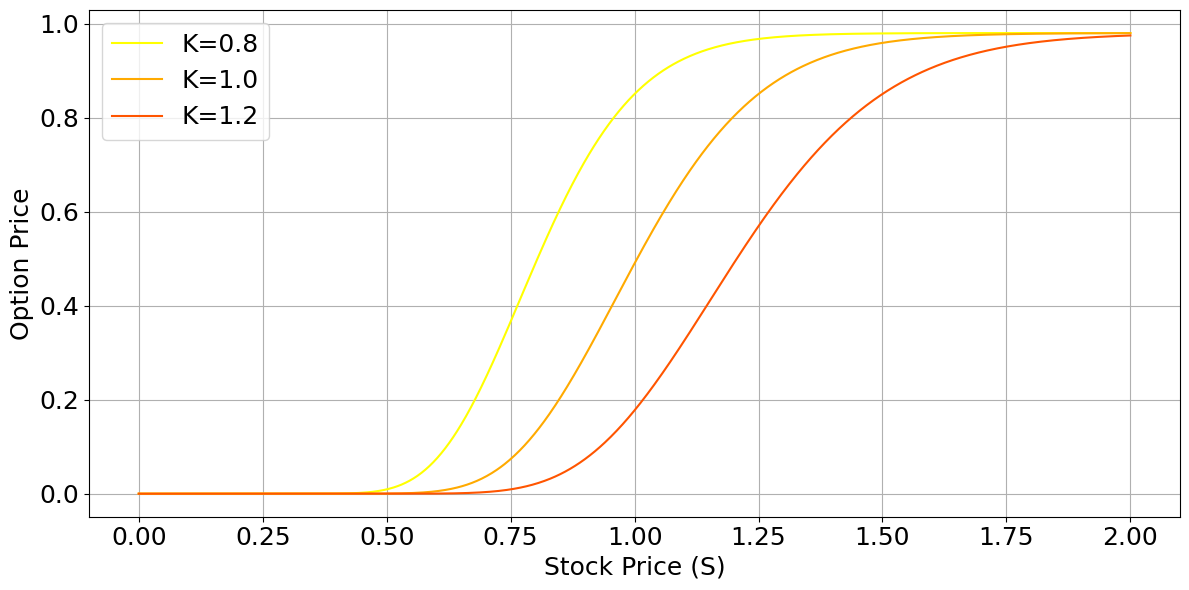

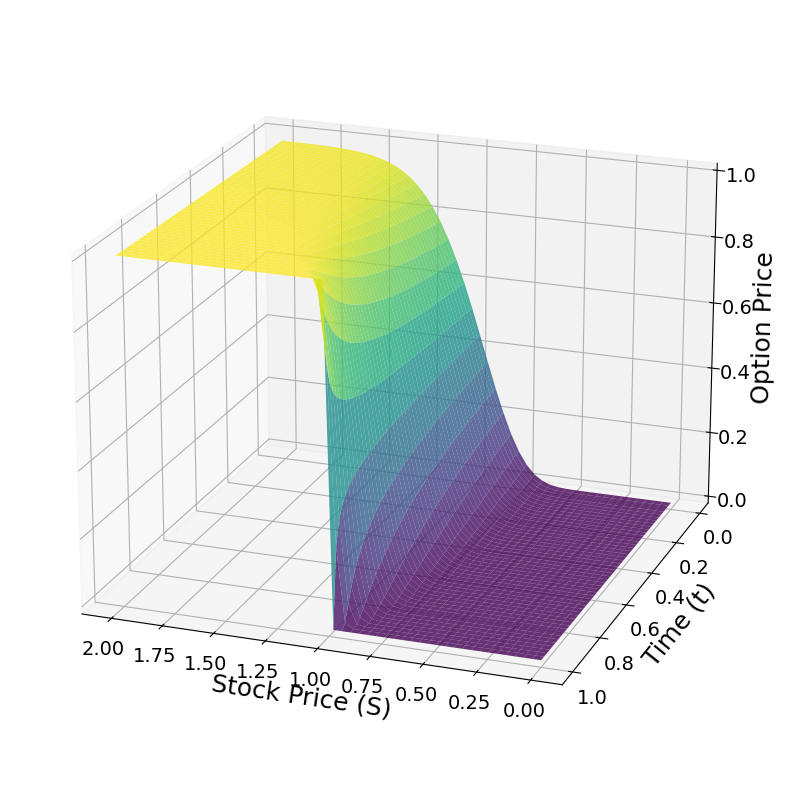

In [9]:
# Sensitivity Analysis
# Varying r, sigma, and K to see their impact

r_values = [0.02, 0.05, 0.1]
sigma_values = [0.05, 0.2, 0.5]
K_values = [0.8, 1.0, 1.2]

def sensitivity_analysis(param_name, param_values, fixed_params):
    """Function to compute option prices for different parameters"""
    plt.figure(figsize=(12, 6))

    cmap = cm.get_cmap('autumn')
    colors = [cmap(1 - i / (len(resolutions) - 1)) for i in range(len(resolutions))]

    for i, value in enumerate(param_values):
        params = fixed_params.copy()
        params[param_name] = value
        
        option_prices = binary_call_analytical(S_grid, 0, params['K'], 
                                               params['r'], params['sigma'], params['T'])
        
        plt.plot(S_grid, option_prices, label=f'{param_name}={value}', color=colors[i])
    
    plt.grid(True)
    plt.xlabel('Stock Price (S)', fontsize=18)
    plt.ylabel('Option Price', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

fixed_params = {'K': K, 'r': r, 'sigma': sigma, 'T': T}

sensitivity_analysis('r', r_values, fixed_params)
sensitivity_analysis('sigma', sigma_values, fixed_params)
sensitivity_analysis('K', K_values, fixed_params)

# Plot the digital option surface c(S,t)
S_plot = np.linspace(0, 2, 50)
t_plot = np.linspace(0, T, 50)
S_mesh, t_mesh = np.meshgrid(S_plot, t_plot)
option_surface = np.zeros_like(S_mesh)

for i in range(len(t_plot)):
    for j in range(len(S_plot)):
        option_surface[i, j] = binary_call_analytical(S_plot[j], t_plot[i], K, r, sigma, T)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_mesh, t_mesh, option_surface, cmap='viridis', alpha=0.8)
ax.set_xlabel('Stock Price (S)', fontsize=18)
ax.set_ylabel('Time (t)',fontsize=18)
ax.set_zlabel('Option Price',fontsize=18)
ax.tick_params(axis='x', which='major', labelsize=14)   
ax.tick_params(axis='y', which='major', labelsize=14)   
ax.tick_params(axis='z', which='major', labelsize=14)  

# ax.set_title('Binary Option Price Surface c(S,t)')
ax.view_init(elev=20, azim=110)
# fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

# Experiment Implicit

C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\2480550481.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('autumn')


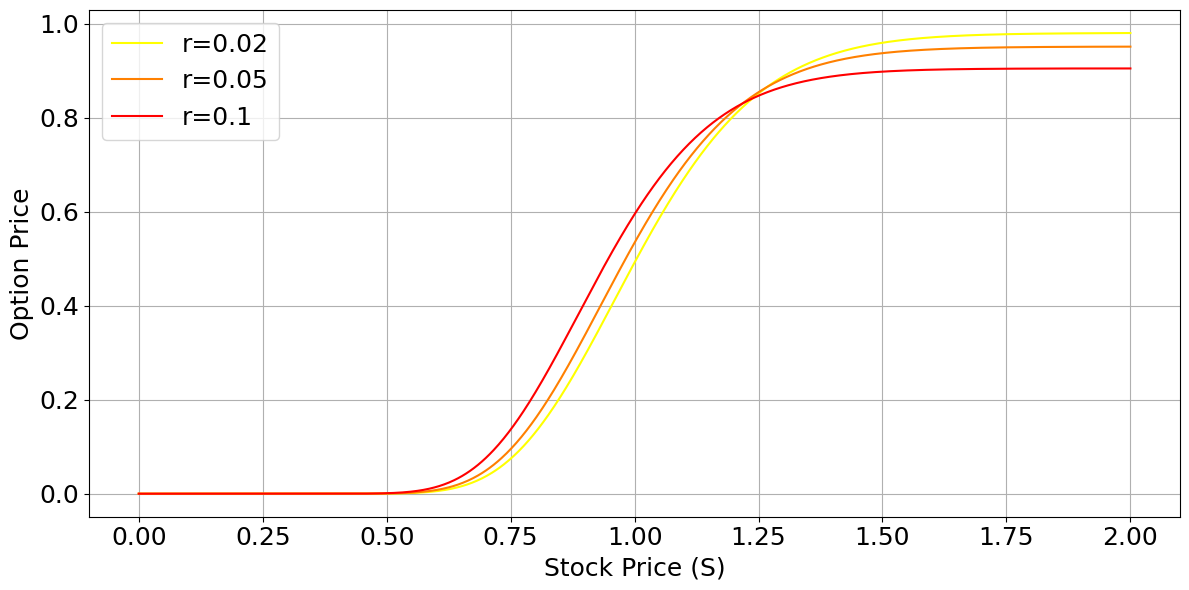

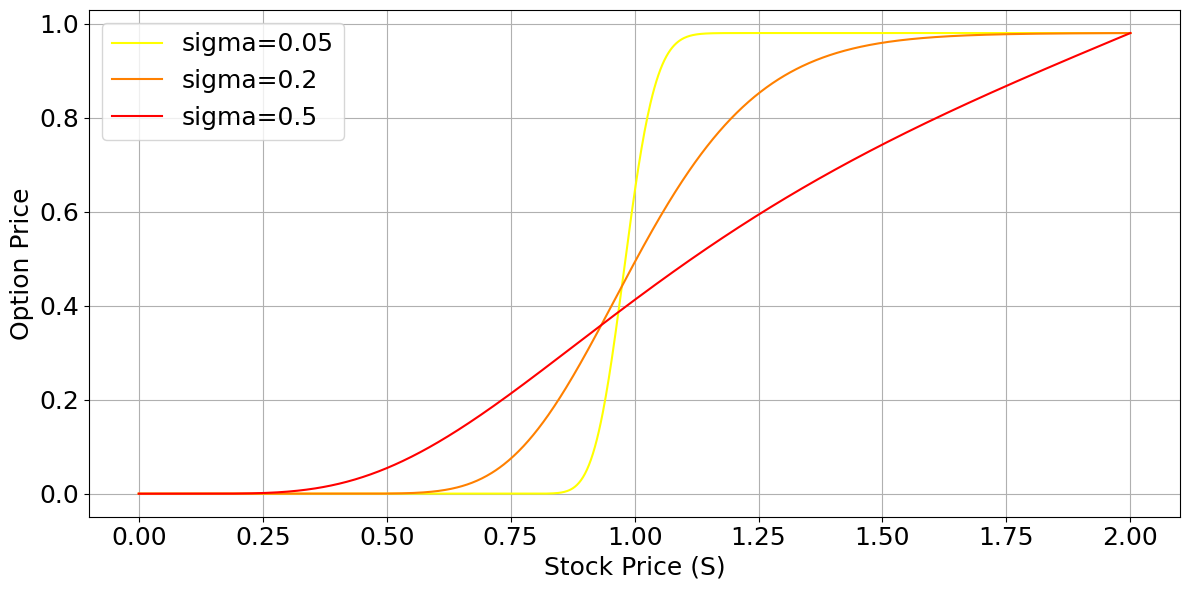

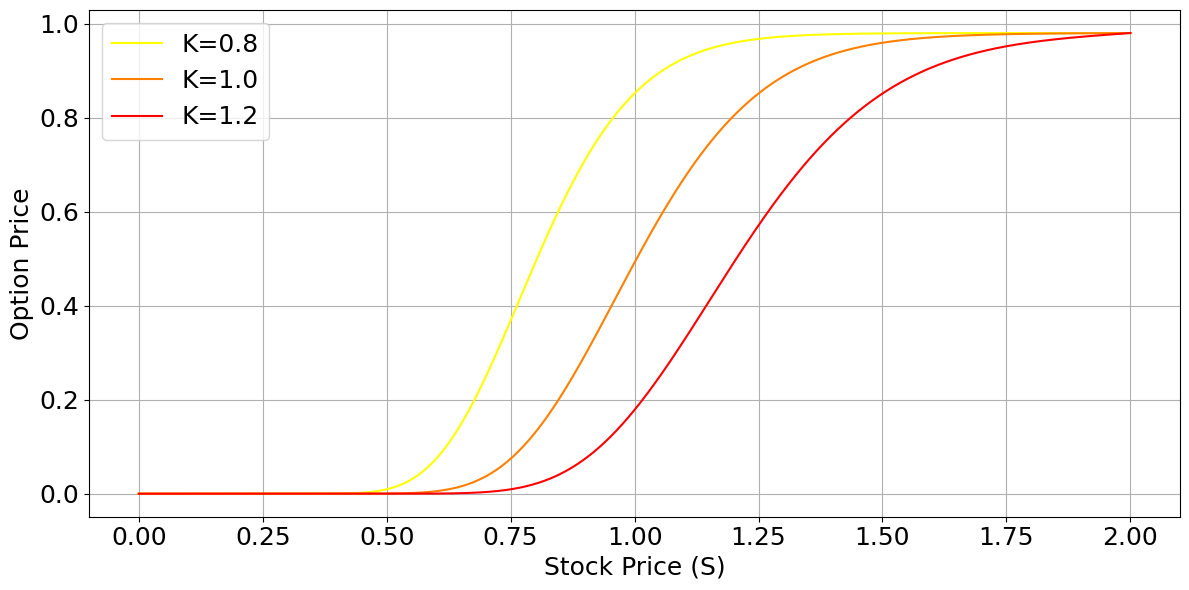

C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\46392093.py:25: RuntimeWarning: divide by zero encountered in log
  d_minus = ((r - sigma**2/2) * tau + np.log(S/K)) / (sigma * np.sqrt(tau))


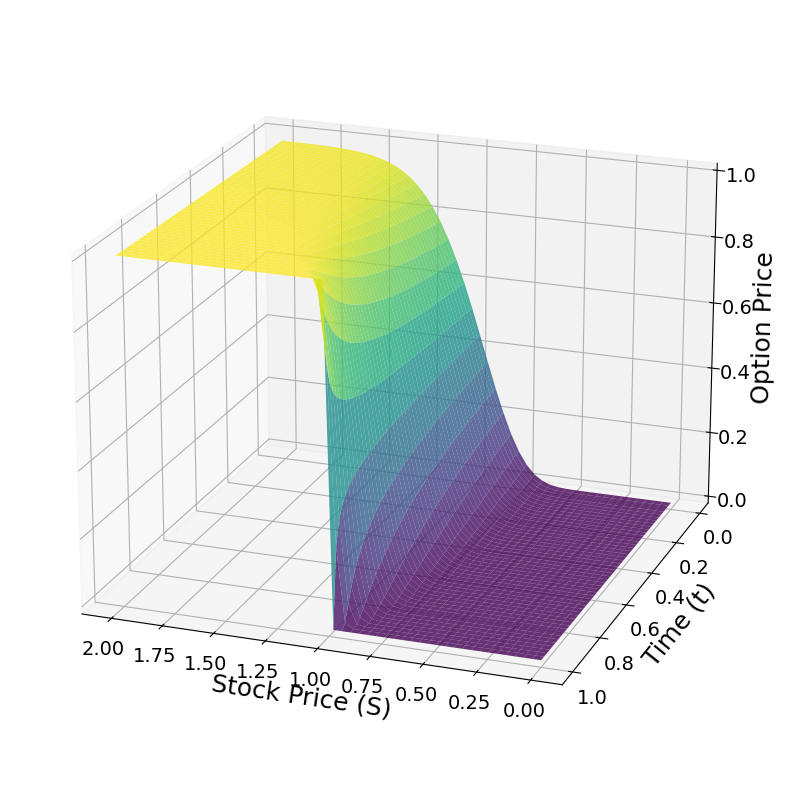

In [10]:
r_values = [0.02, 0.05, 0.1]
sigma_values = [0.05, 0.2, 0.5]
K_values = [0.8, 1.0, 1.2]

def sensitivity_analysis_implicit(param_name, param_values, fixed_params):
    """Sensitivity analysis using the implicit method with reversed autumn colormap"""
    plt.figure(figsize=(12, 6))

    cmap = cm.get_cmap('autumn')
    colors = [cmap(1 - i / (len(param_values) - 1)) for i in range(len(param_values))]

    for i, value in enumerate(param_values):
        params = fixed_params.copy()
        params[param_name] = value

        # Rebuild grid to ensure matching sizes
        S_grid = np.linspace(Smin, Smax, M + 1)
        t_grid = np.linspace(0, T, N + 1)

        # Compute option price using implicit method
        V = binary_call_implicit(S_grid, t_grid,
                                 K=params['K'],
                                 r=params['r'],
                                 sigma=params['sigma'],
                                 T=params['T'])

        plt.plot(S_grid, V[:, 0], label=f'{param_name}={value}', color=colors[i])

    plt.grid(True)
    plt.xlabel('Stock Price (S)', fontsize=18)
    plt.ylabel('Option Price', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

# Run for all parameter variations
fixed_params = {'K': K, 'r': r, 'sigma': sigma, 'T': T}
sensitivity_analysis_implicit('r', r_values, fixed_params)
sensitivity_analysis_implicit('sigma', sigma_values, fixed_params)
sensitivity_analysis_implicit('K', K_values, fixed_params)

# Plot the digital option surface c(S,t)
S_plot = np.linspace(0, 2, 50)
t_plot = np.linspace(0, T, 50)
S_mesh, t_mesh = np.meshgrid(S_plot, t_plot)
option_surface = np.zeros_like(S_mesh)

for i in range(len(t_plot)):
    for j in range(len(S_plot)):
        option_surface[i, j] = binary_call_analytical(S_plot[j], t_plot[i], K, r, sigma, T)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_mesh, t_mesh, option_surface, cmap='viridis', alpha=0.8)
ax.set_xlabel('Stock Price (S)', fontsize=18)
ax.set_ylabel('Time (t)', fontsize=18)
ax.set_zlabel('Option Price', fontsize=18)
# ax.set_title('Binary Option Price Surface c(S,t)')
ax.tick_params(axis='x', which='major', labelsize=14)   
ax.tick_params(axis='y', which='major', labelsize=14)   
ax.tick_params(axis='z', which='major', labelsize=14)
ax.view_init(elev=20, azim=110)
# fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()



# Experiment Crank

C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\596430859.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('autumn')


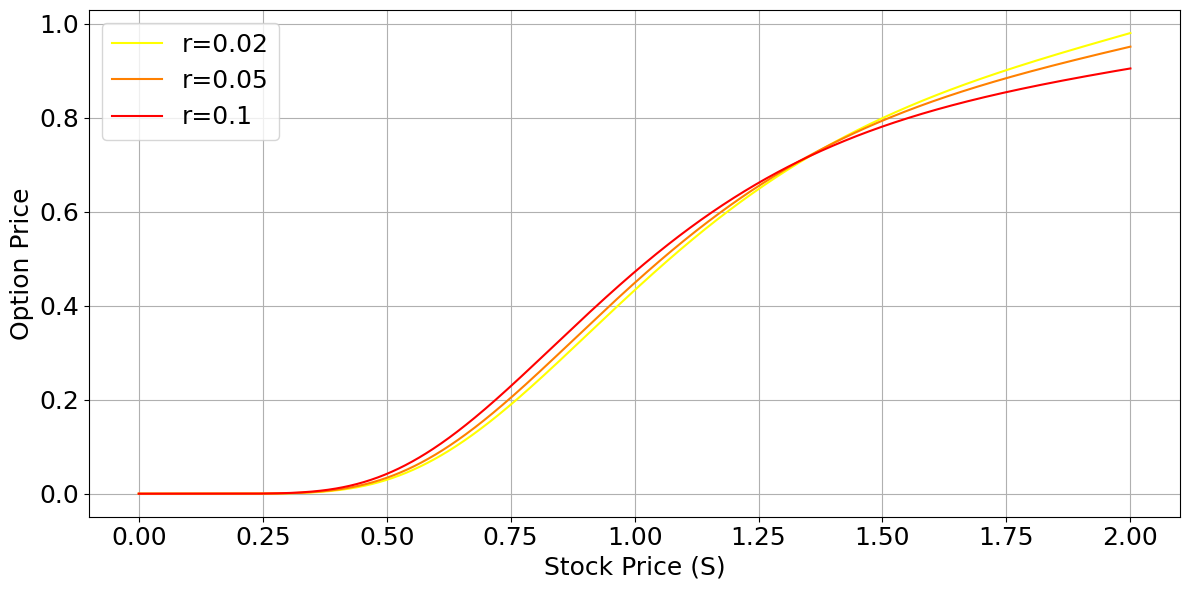

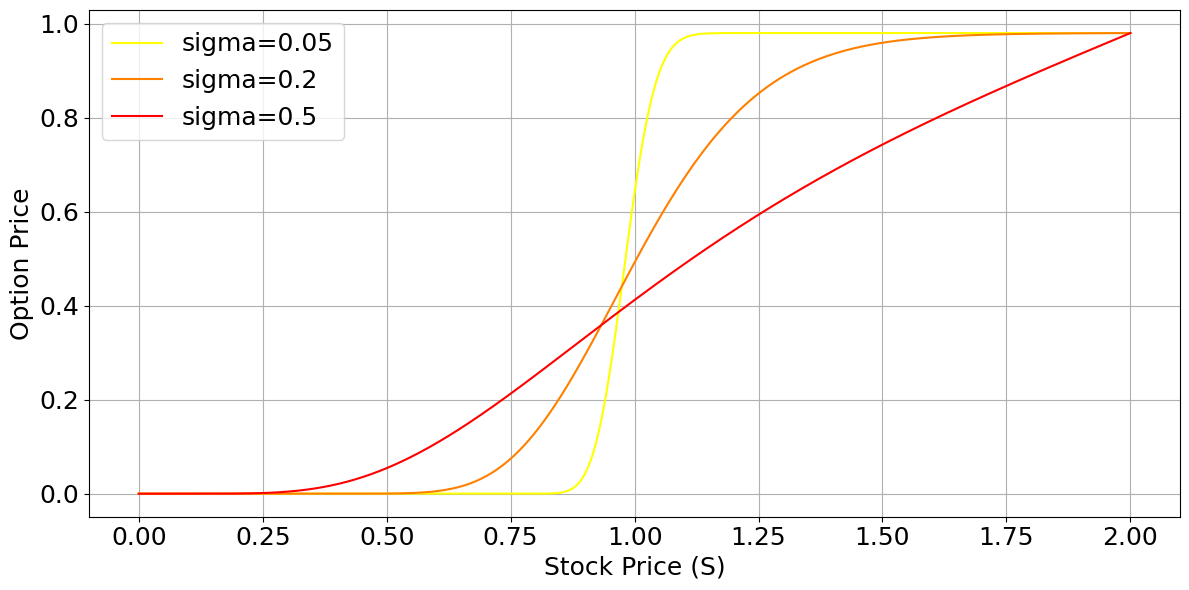

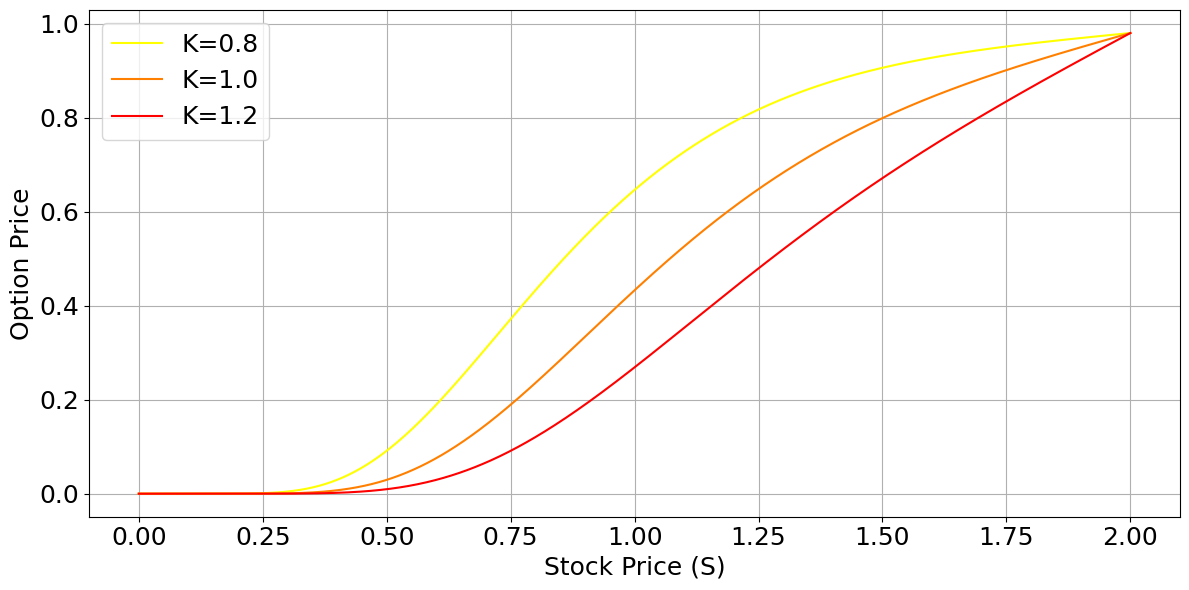

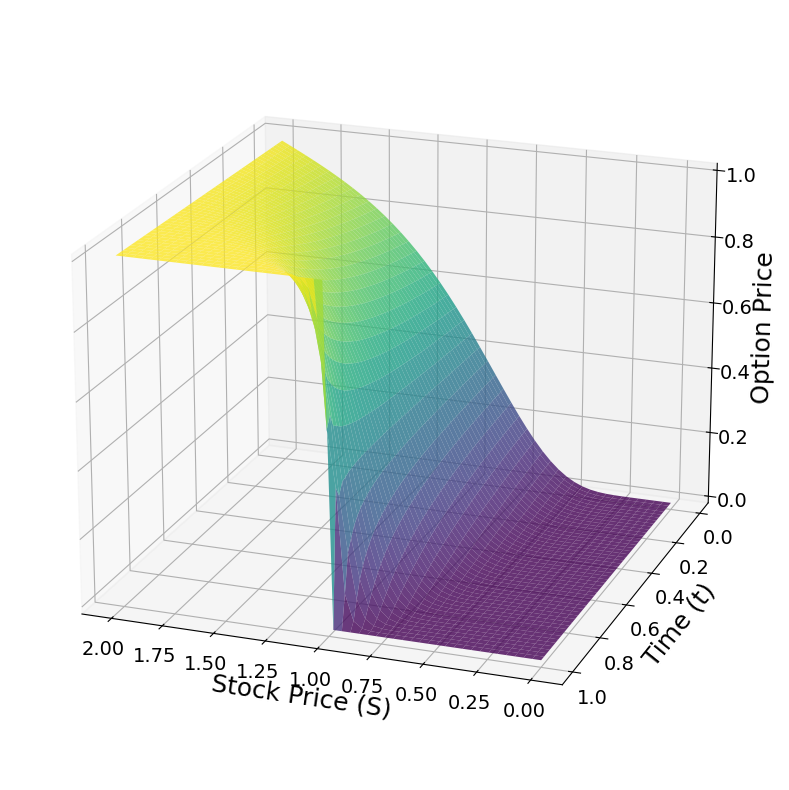

In [ ]:
# Sensitivity parameter sets
r_values = [0.02, 0.05, 0.1]
sigma_values = [0.05, 0.2, 0.5]
K_values = [0.8, 1.0, 1.2]

def sensitivity_analysis_cn(param_name, param_values, fixed_params):
    """Sensitivity analysis using the Crank-Nicolson method with reversed autumn colormap"""
    plt.figure(figsize=(12, 6))

    cmap = cm.get_cmap('autumn')
    colors = [cmap(1 - i / (len(param_values) - 1)) for i in range(len(param_values))]

    for i, value in enumerate(param_values):
        params = fixed_params.copy()
        params[param_name] = value

        # Rebuild grid
        S_grid = np.linspace(Smin, Smax, M + 1)
        t_grid = np.linspace(0, T, N + 1)

        # Compute option prices using Crank-Nicolson
        V = binary_call_crank_nicolson(S_grid, t_grid,
                                       K=params['K'],
                                       r=params['r'],
                                       sigma=params['sigma'],
                                       T=params['T'])

        plt.plot(S_grid, V[:, 0], label=f'{param_name}={value}', color=colors[i])

    plt.grid(True)
    plt.xlabel('Stock Price (S)', fontsize=18)
    plt.ylabel('Option Price', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # plt.title(f'Sensitivity to {param_name} (Crank-Nicolson Method)', fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

# Run for all parameter variations
fixed_params = {'K': K, 'r': r, 'sigma': sigma, 'T': T}
sensitivity_analysis_cn('r', r_values, fixed_params)
sensitivity_analysis_cn('sigma', sigma_values, fixed_params)
sensitivity_analysis_cn('K', K_values, fixed_params)

# Recreate fine grid
S_plot = np.linspace(0, 2, 50)
t_plot = np.linspace(0, T, 50)
S_mesh, t_mesh = np.meshgrid(S_plot, t_plot)
option_surface_cn = np.zeros_like(S_mesh)

# Grid setup for CN method
M_surface = len(S_plot) - 1
N_surface = len(t_plot) - 1
S_grid_surface = np.linspace(S_plot.min(), S_plot.max(), M_surface + 1)
t_grid_surface = np.linspace(0, T, N_surface + 1)

# Compute Crank-Nicolson solution
V_surface = binary_call_crank_nicolson(S_grid_surface, t_grid_surface, K, r, sigma, T)

# Fill the surface using interpolation over time steps
for i, t in enumerate(t_plot):
    n_idx = np.searchsorted(t_grid_surface, t)
    option_surface_cn[i, :] = np.interp(S_plot, S_grid_surface, V_surface[:, n_idx])

# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_mesh, t_mesh, option_surface_cn, cmap='viridis', alpha=0.8)
ax.set_xlabel('Stock Price (S)', fontsize=18)
ax.set_ylabel('Time (t)', fontsize=18)
ax.set_zlabel('Option Price', fontsize=18)
# ax.set_title('Binary Option Price Surface c(S,t) (Crank-Nicolson Method)')
ax.tick_params(axis='x', which='major', labelsize=14)   
ax.tick_params(axis='y', which='major', labelsize=14)   
ax.tick_params(axis='z', which='major', labelsize=14)
ax.view_init(elev=20, azim=110)
# fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()


C:\Users\TWTNi\AppData\Local\Temp\ipykernel_52960\2480790515.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('autumn')


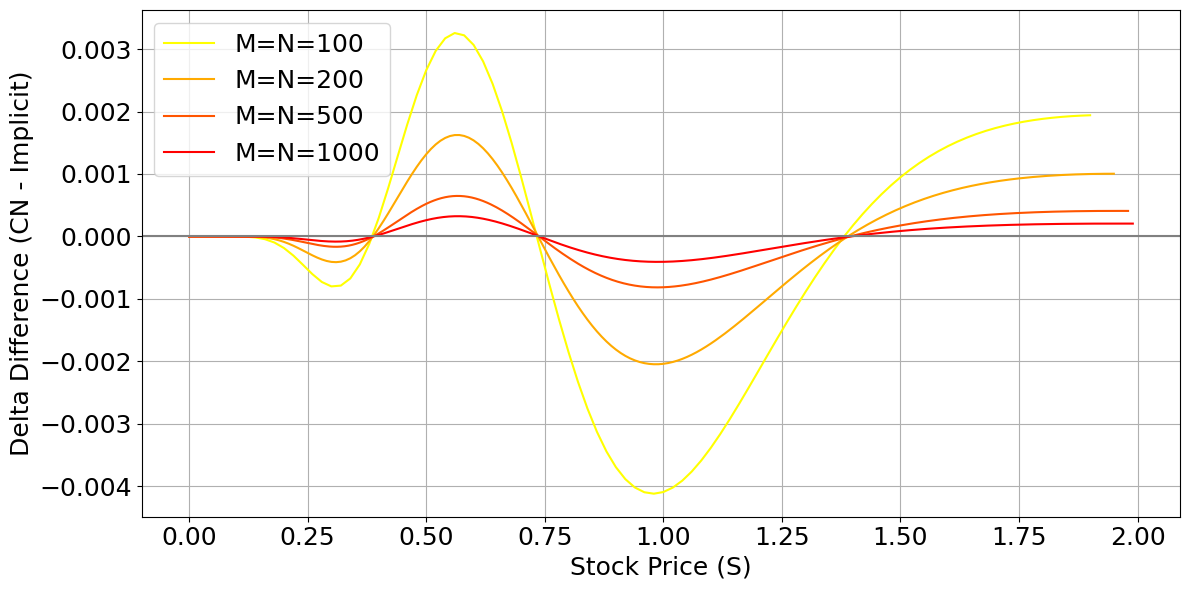

In [12]:
import matplotlib.cm as cm

resolutions = [100, 200, 500, 1000]
cmap = cm.get_cmap('autumn')
colors = [cmap(1 - i / (len(resolutions) - 1)) for i in range(len(resolutions))]

plt.figure(figsize=(12, 6))

for i, res in enumerate(resolutions):
    M = N = res
    Smin = 0.0
    Smax = 2
    T = 1.0
    K = 1.0
    r = 0.02
    sigma = 0.4
    S_grid = np.linspace(Smin, Smax, M + 1)
    t_grid = np.linspace(0, T, N + 1)
    ds = S_grid[1] - S_grid[0]

    # Compute option values
    V_imp = binary_call_implicit(S_grid, t_grid, K, r, sigma, T)
    V_cn = binary_call_crank_nicolson(S_grid, t_grid, K, r, sigma, T)

    # Compute delta
    delta_imp = np.zeros(M + 1)
    delta_cn = np.zeros(M + 1)
    for j in range(1, M):
        delta_imp[j] = (V_imp[j+1, 0] - V_imp[j-1, 0]) / (2 * ds)
        delta_cn[j] = (V_cn[j+1, 0] - V_cn[j-1, 0]) / (2 * ds)
    delta_imp[0] = (V_imp[1, 0] - V_imp[0, 0]) / ds
    delta_imp[M] = (V_imp[M, 0] - V_imp[M-1, 0]) / ds
    delta_cn[0] = (V_cn[1, 0] - V_cn[0, 0]) / ds
    delta_cn[M] = (V_cn[M, 0] - V_cn[M-1, 0]) / ds

    # Plot delta difference (excluding unstable boundary)
    plt.plot(S_grid[:-5], (delta_cn - delta_imp)[:-5], label=f'M=N={res}', color=colors[i])

# Formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Stock Price (S)', fontsize=18)
plt.ylabel('Delta Difference (CN - Implicit)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(0, color='gray')
# plt.title('Delta Difference Between Methods for Increasing Resolution', fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

